# NuMI Neutrino Flux Fun
A quick notebook to look at how to construct a simple NuMI flux at the NOvA detector from decays of pions and kaons. It is particularly interesting to look at how the flux is similar or different between the two detectors.

In [1]:
%run config.py

In [2]:
from particle import PDGID, Particle
from hepunits.units import keV, MeV, GeV
from hepunits import units as u

from NumiBeamline import * #Lazy
from LazyKinematics import LazyKinematics as lk
from LazyKinematics import NeutrinoTarget
from BMPTFlux import BMPTFlux



#import tensorflow as tf
#print(tf.__version__)

## Pion decay point
Obviously for a monoenergetic beam of pions entering the decay pipe, the decays will just follow an exponential distribtuion. The apparent lifetime, $\tau$, will be relativistically boosted relative to the pion lifetime $\tau_{\pi}=2.6033\times10^{-8}$s,
$$\tau = \gamma \tau_\pi$$

In [3]:
pionMass=139.57061*MeV #Mev ->GeV
pionLifetime=2.6033e-8 #seconds
muonMass=105.6583755*MeV #Mev -> GeV
def getPionGamma(E):
    """
    Returns the relativistic gamma for a charged pion with energy E (in GeV)
    Arguments:
        E: the pion energy in MeV
    Returns:
        The relativistic gamma factor
    """
    return E/pionMass

def getPionLifetime(E):
    """
    Returns the relativistically boosted lifetime for a charged pion with energy E (in GeV)
    Arguments:
        E: the pion energy in MeV
    Returns:
        The relativistic boosted lifetime in the lab frame
    """
    return getPionGamma(E)*pionLifetime

def getBetaFromGamma(gamma):
    """
    Returns the relativistic beta from relativistic gamma
    Arguments:
        gamma: relatistic gamma factor
    Returns:
        The relativistic beta (v/c)
    """
    return np.sqrt(1-1./(gamma*gamma))

def getPionDecayLength(E):
    """
    Returns the pion decay length
    Arguments:
        E: the pion energy in MeV
    Returns:
        The pion decay length in mm
    """
    gamma=getPionGamma(E)
    beta=getBetaFromGamma(gamma)
    return scipy.constants.c*beta*getPionLifetime(E)*u.m

def getPionGammaFromP(p):
    return getPionGamma(np.sqrt(p**2 + pionMass**2))
    

Text(0, 0.5, 'Probability')

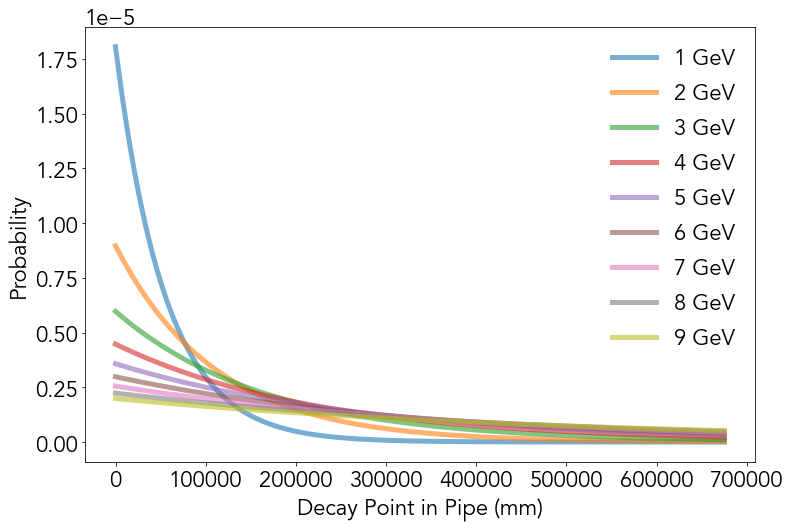

In [4]:
from scipy.stats import expon
fig, ax = plt.subplots()
x=np.linspace(0*u.m,675*u.m,1000) #Position in metres
for E in range(1,10):
    ax.plot(x, expon.pdf(x,scale=getPionDecayLength(E*GeV)), lw=5, alpha=0.6, label=str(E)+' GeV')
ax.legend()
#ax.set_yscale('log')
ax.set_xlabel("Decay Point in Pipe (mm)")
ax.set_ylabel("Probability")

## Neutrino energy and weight
The following code is adapted from G4NuMI (so thanks to Robert Hatcher, Mike Kordosky, et al.)

We will look first at the charged pion decay. The dominate form of this decay is, of course:
$$ \pi^+ \rightarrow \mu^+ + \nu_\mu$$

Since this is a two body decay, in the pion rest frame the energies of the muon and neutrino are explicitly determined. Which can be determined by solving the energy and momentum equations. Some defintions:
$$ Q = m_\pi c^2 - m_\mu c^2$$
$$ m_\pi c^2 = E_\nu + E_\mu $$
$$ 0 = \vec{p}_\nu + \vec{p}_\mu$$
$$ E_\mu = T_\mu + m_\mu c^2 $$
$$ T_\mu = Q - |p|c $$
$$ E_\nu = |p|c = \frac{Q^2 + 2 Q m_\mu c^2}{2Q + 2 m_\mu c^2} =29.79MeV$$


So we have the neutrino energy in the pion rest frame. Now we need to determine the energy a neutrino would have that would hit the detector. The only inputs to this calculation are the parent pion momentum and the detector location and size.

For our toy model we will start by assuming that the $x$ and $y$ components of the pion momentum are normal distribtions with a mean of 0 and a width of 2%, obviously this is a parameter we can play with. We'll also asume that the pion divergence dominates the decay position. So the vertex position is
$$v_\nu = \left(v_x,v_y,v_z\right)=\left(v_z * \frac{dp_x}{dp_z}, v_z*\frac{dp_y}{dp_z},v_z\right)$$
$$ p_\pi =\left( p_x,p_y,p_z \right) $$

The detector position is of course known, but is different for the two detectors. So if our detector is at $P_{d}={x_d,y_d,z_d}$. So the distance from the vertex to the detector is
$$R = P_{d}-v_\nu \\
|R| = \sqrt{(x_d-v_x)^2 +(y_d-v_y)^2 +(z_d-v_z)^2} $$

The angle between the pion momentum and the detect vector is
$$ \cos \theta = \frac{p_\pi \cdot R}{|p_\pi| |R|} $$

The neutrino energy that would hit the detector is given by
$$ E_\nu = E_\nu^{*} * \xi = E_\nu^* \times \frac{1}{\gamma ( 1- |beta| \cos \theta )} $$


Alternatively if the neutrino energy in pion rest frame centre of mass is $E_\nu^*$ and the cosine of the angle is $\cos \theta^*$, then the energy of the neutrino in the lab frame is
$$E_\nu = \gamma E_\nu^* \left(1 + \beta \cos \theta^* \right) $$
and the relationship between the angle in the pion rest frame and lab frame is
$$\cos \theta = \frac{\cos \theta^*  + \beta}{1 + \beta \cos \theta^*}$$
or 
$$\cos \theta^* = \frac{\cos \theta  - \beta}{1 - \beta \cos \theta}$$



In [5]:
def getEnuPion():
    return (pionMass**2 - muonMass**2)/(2*pionMass)

def getCosThetaPion(cosTheta,beta):
    return (cosTheta-beta)/(1-beta*cosTheta)

def getEnuLab(gamma,costheta):
    beta=getBetaFromGamma(gamma)
    cosThetaStar= getCosThetaPion(costheta,beta)
    return gamma * getEnuPion() * (1 + beta *cosThetaStar)

def getEMRat(gamma,costheta):
    beta=getBetaFromGamma(gamma)
    return 1./(gamma*(1-beta*costheta))

def getEnuLabOrig(gamma,costheta):
    return getEnuPion()*getEMRat(gamma,costheta)

def getPionMom(E):
    return np.sqrt(E**2 - pionMass**2)

def getPionEnergy(pionP):
    return np.sqrt(pionP**2 + pionMass**2)
    

pnovaND=[11.7174545*u.m,-3.3151325*u.m,992.9347347*u.m]
pnovaFD=[+11037.296450*u.m, -4162.557681*u.m, 810422.327354*u.m]
    
    

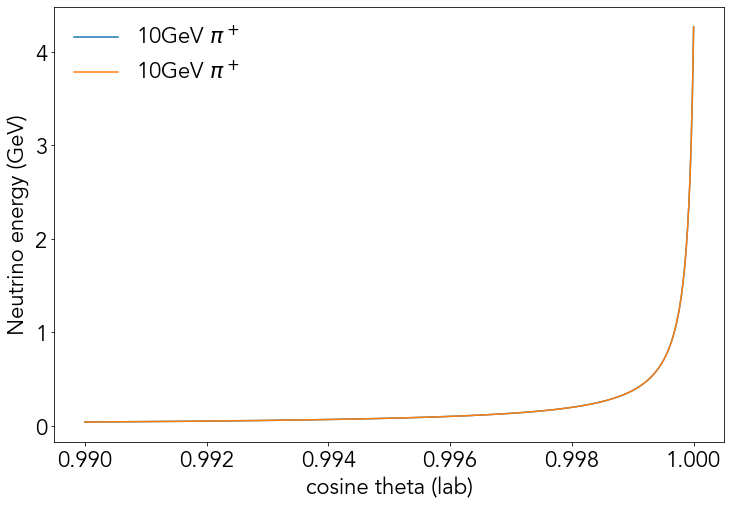

In [6]:
fig, ax = plt.subplots()
ct=np.linspace(0.99,1,1000) #cos theta lab
ax.plot(ct,getEnuLab(getPionGamma(10*GeV),ct)/GeV,label="10GeV $\pi^+$")
ax.plot(ct,getEnuLabOrig(getPionGamma(10*GeV),ct)/GeV,label="10GeV $\pi^+$")  #So they are in agreement
#ax.plot(ct,getEnuLab(getPionGamma(15*GeV),ct),label="15GeV $\pi^+$")
ax.set_xlabel("cosine theta (lab)")
ax.set_ylabel("Neutrino energy (GeV)")
ax.legend()

              


## Toy simulation of pion flux

### BMPT Parameterisation
We can take inspiration for the flux of hadrons coming off the target from the BMPT paramterisation which was put together for the CNGS Beryllium target, https://arxiv.org/abs/hep-ph/0101163. MIPP theses showed that the general shape of these parameterisations were good descriptions of the MIPP pion/kaon ratios https://inspirehep.net/files/1c5fd61155127814ebeb6bfbd6028d00.



## Modelling the NuMI Horns

How easily can we model the NuMI Horns????

Text(0.5, 1.0, 'Simplified NuMI Beamline')

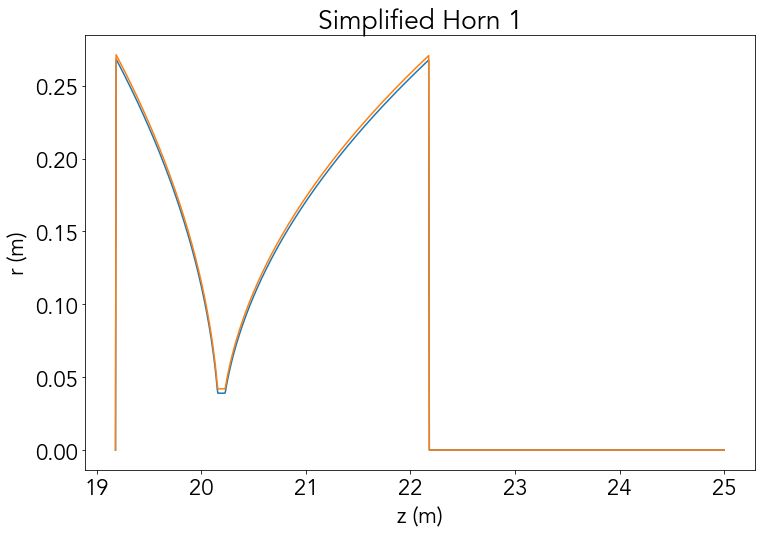

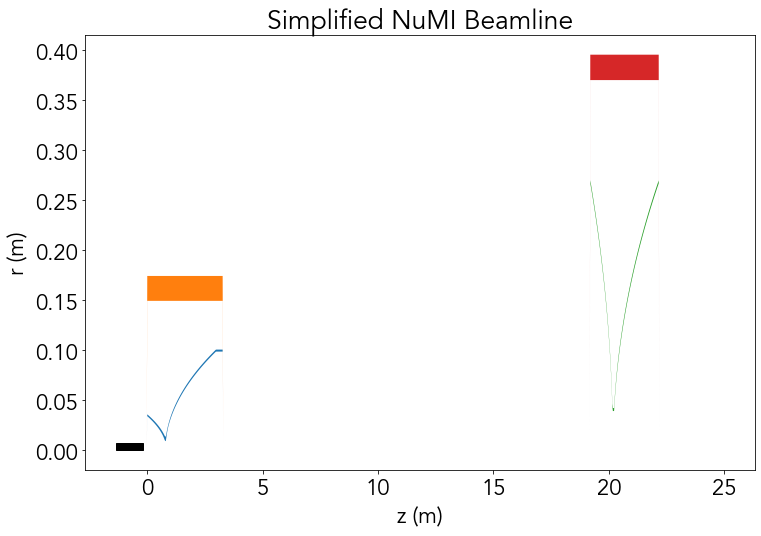

In [7]:
fig, ax = plt.subplots()
z=np.linspace(horn2Start/u.m,25,1000)
#print((z*u.m))
#print(getSimpleHorn2ICRin(z*u.m)/u.m)

#z=np.linspace(-0.1,4,1000)
    
#ax.plot(z,getHorn1OCRout(z))
#ax.plot(z,getHorn1OCRin(z))
#ax.plot(z,getHorn1ICRout(z))
#ax.plot(z,getHorn1ICRin(z))
ax.plot(z,getSimpleHorn2ICRin(z*u.m)/u.m)
ax.plot(z,getSimpleHorn2ICRout(z*u.m)/u.m)
#ax.plot(z,getSimpleHorn2OCRin(z*u.m)/u.m)
#ax.plot(z,getSimpleHorn2OCRout(z*u.m)/u.m)
ax.set_xlabel("z (m)")
ax.set_ylabel("r (m)")
ax.set_title("Simplified Horn 1")


fig, ax = plt.subplots()
z=np.linspace(-0.1,25,1000)
ax.fill_between(z,getSimpleHorn1ICRin(z*u.m)/u.m,getSimpleHorn1ICRout(z*u.m)/u.m)
ax.fill_between(z,getSimpleHorn1OCRin(z*u.m)/u.m,getSimpleHorn1OCRout(z*u.m)/u.m)

ax.fill_between(z,getSimpleHorn2ICRin(z*u.m)/u.m,getSimpleHorn2ICRout(z*u.m)/u.m)
ax.fill_between(z,getSimpleHorn2OCRin(z*u.m)/u.m,getSimpleHorn2OCRout(z*u.m)/u.m)
#add rectangle to plot
ax.add_patch(Rectangle((-1.3755, 0), 1.1755, 0.0074,color='black'))
ax.set_xlabel("z (m)")
ax.set_ylabel("r (m)")
ax.set_title("Simplified NuMI Beamline")


In [ ]:
nt = NeutrinoTarget()
proton=Particle.from_pdgid(2212)
piPlus=Particle.from_pdgid(211)

#Now can we simulate a pion  
tgExit=-1*u.m
pT=0.5*GeV
xr=0.5
pLab=nt.getPlabFromxr(xr,pT,piPlus)
print("pLab",pLab)
pL=np.sqrt(pLab**2 - pT**2)
print(pLab,pT,pL)
cosTheta=pL/pLab
tanTheta=pT/pL
print(cosTheta)

fig, ax = plt.subplots()
z=np.linspace(-0.1,25,1000)
ax.fill_between(z,getSimpleHorn1ICRin(z*u.m)/u.m,getSimpleHorn1ICRout(z*u.m)/u.m)
ax.fill_between(z,getSimpleHorn1OCRin(z*u.m)/u.m,getSimpleHorn1OCRout(z*u.m)/u.m)

ax.fill_between(z,getSimpleHorn2ICRin(z*u.m)/u.m,getSimpleHorn2ICRout(z*u.m)/u.m)
ax.fill_between(z,getSimpleHorn2OCRin(z*u.m)/u.m,getSimpleHorn2OCRout(z*u.m)/u.m)
#add rectangle to plot
ax.add_patch(Rectangle((-1.3755, 0), 1.1755, 0.0074,color='black'))
zHorn=(0-tgExit)/u.m
ax.arrow(tgExit/u.m,0,zHorn,zHorn*tanTheta)
ax.set_xlabel("z (m)")
ax.set_ylabel("r (m)")
ax.set_title("Simplified NuMI Beamline")

print("Arrow 1",tgExit/u.m,0,zHorn,zHorn*tanTheta)
print(tanTheta)
print(zHorn)

numSteps=100
z1=np.linspace(0,3,numSteps)
r1=np.zeros(numSteps)
pt1=np.zeros(numSteps)
r1[0]=zHorn*tanTheta
print("r1[0]",r1[0])
pt1[0]=pT
dz=z1[1]-z1[0]
K=0.3*scipy.constants.mu_0*200e3/(2*math.pi)   #dpt = 0.3 * B * l


print("r0",r1[0])
print("pt diff (3m)",GeV*(K * 3) / (r1[0]))
print("pt diff (1step)",GeV*(K * dz) / (r1[0]*cosTheta))
print("dz/cosTheta",dz/cosTheta)
#print(z1)
horn1IC=getSimpleHorn1ICRout(z1*u.m)/u.m
horn1OC=getSimpleHorn1OCRin(z1*u.m)/u.m
#print("horn1",horn1IC,horn1OC)
for i in range(1,numSteps):
    r1[i]=r1[i-1]+dz*tanTheta
    if(r1[i-1]>horn1IC[i-1] and r1[i-1]<horn1OC[i-1]):
        pt1[i]=pt1[i-1] - GeV*(K * dz) / (r1[i-1]*cosTheta)
    else:
        pt1[i]=pt1[i-1]
    sinTheta=pt1[i]/pLab
    cosTheta=np.sqrt(1-sinTheta**2)
    tanTheta=pt1[i]/np.sqrt(pLab**2 - pt1[i]**2)
    #print(i,r[i],z[i],pt[i],cosTheta,tanTheta)
    
zHorn2=horn2Start/u.m
    
ax.plot(z1,r1)
ax.arrow(z1[-1],r1[-1],zHorn2-z1[-1],(zHorn2-z1[-1])*tanTheta)        

numSteps=100
z2=np.linspace(zHorn2,zHorn2+3,numSteps)
r2=np.zeros(numSteps)
pt2=np.zeros(numSteps)
r2[0]=r1[-1] + (zHorn2-z1[-1])*tanTheta 
pt2[0]=pt1[-1]
dz=z2[1]-z2[0]

horn2IC=getSimpleHorn2ICRout(z2*u.m)/u.m
horn2OC=getSimpleHorn2OCRin(z2*u.m)/u.m
for i in range(1,numSteps):
    r2[i]=r2[i-1]+dz*tanTheta
    if(r2[i-1]>horn2IC[i-1] and r1[i-1]<horn2OC[i-1]):
        pt2[i]=pt2[i-1] - GeV*(K * dz) / (r2[i-1]*cosTheta)
    else:
        pt2[i]=pt2[i-1]
    sinTheta=pt2[i]/pLab
    cosTheta=np.sqrt(1-sinTheta**2)
    tanTheta=pt2[i]/np.sqrt(pLab**2 - pt2[i]**2)

ax.plot(z2,r2)
    

fig, ax = plt.subplots()
ax.plot(z1,pt1)



pLab 62772.64356208921
62772.64356208921 500.0 62770.65221720338
0.9999682768675521
Arrow 1 -1.0 0 1.0 0.007965505890712514
0.007965505890712514
1.0
r1[0] 0.007965505890712514
r0 0.007965505890712514
pt diff (3m) 4519.486962098942
pt diff (1step) 45.65283170637173
dz/cosTheta 0.030303991640570817


In [ ]:
import matplotlib.colors as colors

bmpt=BMPTFlux()

tgExit=-1.4*u.m
pT=1*GeV #np.linspace(0*GeV,0.8*GeV,1)
xr=1

#print("xr",xr)
pLab=nt.getPlabFromxr(xr,pT,Particle.from_name("pi+"))
pL=np.sqrt(pLab**2 - pT**2)
#print("p,p,p",pLab,pT,pL)


numi =NumiBeamline()
xrMin=0.001
xrMax=0.5
ptMin=0.01
ptMax=5
#xrMin=0.55
#xrMax=0.6
#ptMin=0.13
#ptMax=0.14

xrVals,ptVals = np.mgrid[xrMin:xrMax:0.001, ptMin:ptMax:0.05]
ptVals*=GeV


#print("xr",xrVals)
#print("ptVals",ptVals)


pLab=nt.getPlabFromxr(xrVals,ptVals,Particle.from_name("pi+"))

ptVals[np.isnan(pLab)]=np.nan
xrVals[np.isnan(pLab)]=np.nan

fig, ax = plt.subplots()
cb=ax.imshow(xrVals,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$x_R$ Debug")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label("$x_r$")


flux=bmpt.getPiKFlux(Particle.from_name("pi+"),xrVals,ptVals)
fmax=flux[np.isfinite(flux)].max()
fmin=flux[np.isfinite(flux)].min()


fig, ax = plt.subplots()
cb=ax.imshow(flux,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto',norm=colors.LogNorm(vmin=fmin, vmax=fmax))
                                                                                                    
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("Flux $pi^+$")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label("flux")


fig, ax = plt.subplots()
cb=ax.imshow(pLab,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("Pion Momentum @ Target Exit")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label("$p_{lab}$")

pL=np.sqrt(pLab**2 - ptVals**2)
#print("p,p,p",pLab,ptVals,pL)

print(np.min(numi.horn1IC),np.max(numi.horn1OC))

particle,z,r,pT,pLab=numi.targetToHorn1(Particle.from_name("pi+"),tgExit,0,ptVals,pLab)

fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto',vmin=np.min(numi.horn1IC[numi.horn1IC>0]),vmax=np.max(numi.horn1OC))
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("r @ Horn 1 Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))



#print("At Horn1",particle,z,r,pT,pLab)
particle,z,r,pT,pLab=numi.throughHorn1(particle,z,r,pT,pLab)

fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("r @ Horn 1 End")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))



#print("After Horn1",particle,z,r,pT,pLab)
particle,z,r,pT,pLab=numi.horn1ToHorn2(particle,z,r,pT,pLab)
fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("r & Horn 2 Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))


fig, ax = plt.subplots()
cb=ax.imshow(pT,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$p_T$ @ Horn 2 Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$p_T @ z="+str(z)+"$"))



#print("At Horn2",particle,z,r,pT,pLab)
particle,z,r,pT,pLab=numi.throughHorn2(particle,z,r,pT,pLab)
fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$r$ @ Horn 2 End")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))


particle,z,r,pT,pLab=numi.horn2ToDecayPipe(particle,z,r,pT,pLab)

fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$r$ @ Decay Pipe Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))


fig, ax = plt.subplots()
cb=ax.imshow(r,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto',vmin=-1*u.m,vmax=+1*u.m)
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$r$ @ Decay Pipe Start (zoom)")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))



fig, ax = plt.subplots()
cb=ax.imshow(pT,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$p_T$ @ Decay Pipe Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$r_{z="+str(z)+"}$"))


fig, ax = plt.subplots()
cb=ax.imshow(pLab,origin='lower',extent=[ptMin,ptMax,xrMin,xrMax],aspect='auto')
ax.set_xlabel("$p_T$")
ax.set_ylabel("$x_r$")
ax.set_title("$p_{lab}$ @ Decay Pipe Start")
cbar=fig.colorbar(cb, extend='max')
cbar.set_label(("$p_{lab} @ z=$"+str(z)+"mm"))






In [ ]:
rbins=np.linspace(-1250,1250,200)
fig, ax = plt.subplots()
ax.hist(r.ravel(),alpha=0.2, density=True,label="No Weights",bins=rbins)
ax.hist(r.ravel(),alpha=0.2, weights=flux.ravel(),density=True,label="$\pi^+$ flux",bins=rbins)
ax.set_xlabel("$r$ at decay pipe start")
ax.legend()

fig, ax = plt.subplots()
ax.hist(pT.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(pT.ravel(),alpha=0.2, weights=flux.ravel(),density=True,label="$\pi^+$ flux",bins=200)
ax.set_xlabel("$p_T$ at decay pipe start")
ax.set_yscale('log')
ax.legend()


fig, ax = plt.subplots()
ax.hist(pLab.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(pLab.ravel(),alpha=0.2, weights=flux.ravel(),density=True,label="$\pi^+$ flux",bins=200)
ax.set_xlabel("$p_{lab}$ at decay pipe start")
ax.set_yscale('log')
ax.legend()

pionGamma=getPionGamma(np.sqrt(pLab**2-pT**2))

fig, ax = plt.subplots()
ax.hist(pionGamma.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(pionGamma.ravel(),alpha=0.2, weights=flux.ravel(),density=True,label="$\pi^+$ flux",bins=200)
ax.set_xlabel("$\gamma$ at decay pipe start")
ax.set_yscale('log')
ax.legend()


numPhi=90
phi=np.linspace(0,2*math.pi,numPhi)
cosphi=np.cos(phi)
sinphi=np.sin(phi)

xArray = np.array([ r *cp for cp in cosphi])
yArray = np.array([ r *sp for sp in sinphi])
pxArray = np.array([ pT *cp for cp in cosphi])
pyArray = np.array([ pT *sp for sp in sinphi])
fluxArray = np.array( [flux for sp in sinphi])

print(xArray.shape)

#r3d = np.tile(Epion, (numVz, Epion.shape[0],Epion.shape[1]))
#Epion3d = np.moveaxis(Epion3d,0,-1)

fig, ax = plt.subplots()
ax.hist(pxArray.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(pxArray.ravel(),alpha=0.2, weights=fluxArray.ravel(),density=True,label="$\pi^+$ flux",bins=200)
ax.set_xlabel("$p_x$ at decay pipe start")
#ax.set_yscale('log')
ax.legend()


fig, ax = plt.subplots()
ax.hist(xArray.ravel(),alpha=0.2, density=True,label="No Weights",bins=rbins)
ax.hist(xArray.ravel(),alpha=0.2, weights=fluxArray.ravel(),density=True,label="$\pi^+$ flux",bins=rbins)
ax.set_xlabel("$x$ at decay pipe start")
ax.legend()




In [ ]:
print("The shape of all the arrays is", pT.shape)
Epion=getPionEnergy(pLab)

fig, ax = plt.subplots()
ax.hist(Epion.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(Epion.ravel(),alpha=0.2, weights=flux.ravel(),density=True,label="$\pi^+$ flux",bins=200)
ax.set_xlabel("$\pi^+$ energy (MeV) at decay pipe start")
ax.set_yscale('log')
ax.legend()

#Now we need to extend the axis so that for each pion we have multiple z-decay points

numVz=100
#Epion3d = np.tile(Epion, (numVz, Epion.shape[0],Epion.shape[1]))   
#Epion3d = np.moveaxis(Epion3d,0,-1)

vzMin=tgExit*u.m
vzMax=(675+46)*u.m
vz=np.linspace(vzMin,vzMax,100)
print(vz.shape)
#print(Epion3d.shape)
#decayProb=expon.pdf(vz,scale=getPionDecayLength(Epion3d)) #Seems to be very slow



In [ ]:
from scipy.stats import norm
from scipy.stats import expon


from scipy.interpolate import interp1d
zVals=np.array([0,950,2450,3800,7100,12100,17100,22100,27100,32100,37100,42100,47100,62100,80000])
zVals=zVals*u.cm
xmeanVals=np.array([0.0255273,0.0255273,0.00761181,0.00781563,0.00773411,0.00755678,0.00775308,0.00695702,0.00589955,0.00431314,0.00292466,0.00207884,0.00152432,0.00235318,0.00235318])
xsigmaVals=np.array([0.057936,0.057936,0.0295778,0.02775,0.0257604,0.0250169,0.022999,0.0203107,0.0175081,0.0153979,0.0140621,0.0121932,0.0106983,0.0111235,0.0111235])
ymeanVals=np.array([-0.00744807,-0.00744807,-0.00407467,-0.0024235,-0.00339991,-0.00364182,-0.00279323,-0.00239749,-0.00220937,-0.00145244,-0.000412294,4.05251e-05,-0.00158564,-0.000807452,-0.000807452])
ysigmaVals=np.array([0.0505967,0.0505967,0.0280024,0.0264037,0.0253645,0.023817,0.0219022,0.0183993,0.0157606,0.0145364,0.0134245,0.011635,0.0107038,0.0109915,0.0109915])
fMeanX=interp1d(zVals,xmeanVals*GeV)
fSigmaX=interp1d(zVals,xsigmaVals*GeV)
fMeanY=interp1d(zVals,ymeanVals*GeV)
fSigmaY=interp1d(zVals,ysigmaVals*GeV)


x = np.linspace(norm.ppf(0.01,scale=0.02*GeV),norm.ppf(0.99,scale=0.02*GeV), 100)
fig, ax = plt.subplots()
ax.plot(x, norm.pdf(x,loc=fMeanX(50*u.m),scale=fSigmaX(50*u.m)), lw=5, alpha=0.6, label='50m')
#ax.plot(x, norm.pdf(x,loc=fMeanX(100*u.m),scale=fSigmaX(100*u.m)), lw=5, alpha=0.6, label='100m')
ax.plot(x, norm.pdf(x,loc=fMeanX(250*u.m),scale=fSigmaX(250*u.m)), lw=5, alpha=0.6, label='250m')
ax.plot(x, norm.pdf(x,loc=fMeanX(550*u.m),scale=fSigmaX(550*u.m)), lw=5, alpha=0.6, label='550m')
ax.set_xlabel(r" $dp_x$ (MeV)")
ax.legend()
fig, ax = plt.subplots()
ax.plot(x, norm.pdf(x,loc=fMeanY(50*u.m),scale=fSigmaY(50*u.m)), lw=5, alpha=0.6, label='50m')
ax.plot(x, norm.pdf(x,loc=fMeanY(250*u.m),scale=fSigmaY(250*u.m)), lw=5, alpha=0.6, label='250m')
ax.plot(x, norm.pdf(x,loc=fMeanY(550*u.m),scale=fSigmaY(550*u.m)), lw=5, alpha=0.6, label='550m')
ax.set_xlabel(r" $dp_y$ (MeV)")
ax.legend()

In [ ]:
def testEnergy(vx,vy,vz,px,py,pz,isFD=False):
    rD_x=pnovaND[0]-vx
    rD_y=pnovaND[1]-vy
    rD_z=pnovaND[2]-vz
    if isFD:
        rD_x=pnovaFD[0]-vx
        rD_y=pnovaFD[1]-vy
        rD_z=pnovaFD[2]-vz
          
    rMag=np.sqrt(rD_x**2 + rD_y**2 +rD_z**2)
    pionP=np.sqrt(px**2 + py**2 + pz**2)
    E=np.sqrt(pionP**2 + pionMass**2)
    costheta=(rD_x*px + rD_y*py +rD_z*pz)/(pionP*rMag)
    return getEnuLab(getPionGamma(E),costheta)

tvx        = 0
tvy        = 0
tvz        = 4600.9
tvx=tvx/100
tvy=tvy/100
tvz=tvz/100
tpx      = 0.0017237
tpy      = -0.00997162
tpz      = 10
print(testEnergy(tvx,tvy,tvz,tpx,tpy,tpz))

fig, ax = plt.subplots()
tpx=np.linspace(-0.5,0.5,1000)
ax.plot(tpx,testEnergy(tvx,tvy,tvz,tpx,tpy,tpz,True),label="FD $p_z=$"+str(tpz)+ "GeV")
ax.plot(tpx,testEnergy(tvx,tvy,tvz,tpx,tpy,tpz,False),label="ND $p_z=$"+str(tpz)+ "GeV")
#ax.plot(tpx,testEnergy(tvx,tvy,tvz,tpx,tpy,20),label="ND $p_z=20$ GeV")
#ax.plot(tpx,testEnergy(tvx,tvy,tvz,tpx,tpy,30),label="ND $p_z=30$ GeV")
ax.set_xlabel("Pion $p_x$")
ax.set_ylabel("Neutrino Energy")
ax.legend()


In [ ]:
from scipy.stats import multivariate_normal
pionP=getPionMom(10)

px, py = np.mgrid[-0.1:0.1:.001, -0.1:0.1:.001]

#px^2 + py^2 +pz^2 = p^2
# (dx^2 +dy^2 + 1 ) * pz^2 = p^2
# pz^2 = p^2 / (dx^2 +dy^2 + 1 )

pos = np.dstack((px, py))

probx = norm.pdf(px,scale=0.01)
proby = norm.pdf(py,scale=0.01)
totprob = probx*proby
totprob = totprob / np.sum(totprob)
print(totprob.shape)

fig2 = plt.figure() 
ax2 = fig2.add_subplot(111)
im=ax2.imshow(totprob,origin='lower', interpolation='none', extent=[-0.1,0.1,-0.1,0.1])
cb = fig2.colorbar(im)
ax2.set_xlabel("$p_x$")
ax2.set_ylabel("$p_y$")




In [ ]:
#Add back in missing pion flux logarithmic.... why did I delete that???
from scipy.stats import lognorm
tscale=8
mean, var, skew, kurt = lognorm.stats(s=0.5,scale=tscale, moments='mvsk')
x = np.linspace(0*GeV,30*GeV, 100)
fig, ax = plt.subplots()
rvln = lognorm(s=0.5,scale=tscale*GeV)
rvln2 = lognorm(s=0.5,scale=(tscale+0.5)*GeV)

ax.plot(x, rvln.pdf(x),lw=5, alpha=0.6, label='lognorm pdf')
ax.plot(x, rvln2.pdf(x),lw=5, alpha=0.6, label='lognorm pdf')
print(mean,var)

In [ ]:
epMin=1*GeV #GeV  -- Integer for now
epMax=30*GeV #GeV
vzMin=46*u.m
vzMax=(675+46)*u.m
px, py, vz, Epion = np.mgrid[-0.1*GeV:0.1*GeV:.0025*GeV, -0.1*GeV:0.1*GeV:.0025*GeV, vzMin:vzMax:10*u.m,epMin:epMax:0.25*GeV]
#vx=0
#vy=0
#Epion=10
pionP=getPionMom(Epion)
probE=rvln.pdf(Epion)
probE2=rvln2.pdf(Epion)
probX= norm.pdf(px,loc=fMeanX(vz),scale=fSigmaX(vz))
probY= norm.pdf(py,loc=fMeanY(vz),scale=fSigmaY(vz))
pz = np.sqrt(pionP**2 - px**2 -py**2)
vx=vz*px/pz
vy=vz*py/pz
totProb = probX*probY*probE

fig, ax = plt.subplots()
im=ax.imshow(totProb[:,:,0,0])
cb = fig.colorbar(im)
print(np.mean(totProb[:,:,0,-1]))

#print(Epion)
print(vz.shape)
print(vz[0,0].shape)

decayProb=expon.pdf(vz,scale=getPionDecayLength(Epion))
totProb=decayProb*totProb
justDecayProb=np.mean(decayProb,axis=(0,1))
justTotProb=np.mean(totProb,axis=(0,1))
#ax.plot(vz[0,0],justDecayProb/justDecayProb[0])

labels=[r"$E_\pi$="+str(i)+" GeV" for i in np.linspace(epMin*GeV,epMax*GeV,int((epMax/GeV-epMin/GeV)/0.25))]


fig, ax = plt.subplots()
# create colormap
cm = plt.cm.viridis(np.linspace(0, 1, Epion.shape[3]))
ax.set_prop_cycle('color', list(cm))
ax.plot(vz[0,0],justDecayProb/justDecayProb[0],label=labels)
ax.set_xlabel("$v_z$ (m)")
ax.set_ylabel("Rel. Pion Decay Prob.")
#ax.legend(prop={'size': 8})
#cb = fig.colorbar(cm)



fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm))
ax.plot(vz[0,0],justTotProb/justTotProb[0],label=labels)
ax.set_xlabel("$v_z$ (m)")
ax.set_ylabel("Rel. Pion Tot. Prob.")
#ax.legend(prop={'size': 8})


In [ ]:
#Actually calculate the neutrino energies and weights

def getNuWeight(rad,gamma,costheta):
    sangdet = ((1*u.m * 1*u.m) /(rad*rad)/ 4.); 
    emrat=getEMRat(gamma,costheta)
    return sangdet * emrat * emrat;



rND_x=pnovaND[0]-vx
rND_y=pnovaND[1]-vy
rND_z=pnovaND[2]-vz
rMagND=np.sqrt(rND_x**2 + rND_y**2 +rND_z**2)
costhetaND=(rND_x*px + rND_y*py +rND_z*pz)/(pionP*rMagND)
EnuND=getEnuLab(getPionGamma(Epion),costhetaND)
nuWeightsND=getNuWeight(rMagND,getPionGamma(Epion),costhetaND)
print(nuWeightsND.shape)



rFD_x=pnovaFD[0]-vx
rFD_y=pnovaFD[1]-vy
rFD_z=pnovaFD[2]-vz
rMagFD=np.sqrt(rFD_x**2 + rFD_y**2 +rFD_z**2)
costhetaFD=(rFD_x*px + rFD_y*py +rFD_z*pz)/(pionP*rMagFD)
EnuFD=getEnuLab(getPionGamma(Epion),costhetaFD)
nuWeightsFD=getNuWeight(rMagFD,getPionGamma(Epion),costhetaFD)


allWeightsND=nuWeightsND*totProb
allWeightsFD=nuWeightsFD*totProb


In [ ]:

#fig, ax = plt.subplots()
#im=ax.imshow(nuWeightsND[:,:,0,0])
#cb = fig.colorbar(im)




fig, ax = plt.subplots()
ax.hist(rND_x.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(rND_x.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=200)
ax.hist(rND_x.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=200)
ax.hist(rND_x.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=200)
ax.set_ylabel("Prob. Density")
ax.set_xlabel(r"Detector X - Vertex X")
ax.legend()



fig, ax = plt.subplots()
ax.hist(rND_y.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(rND_y.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=200)
ax.hist(rND_y.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=200)
ax.hist(rND_y.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=200)
ax.set_ylabel("Prob. Density")
ax.set_xlabel(r"Detector Y - Vertex Y")
ax.legend()



fig, ax = plt.subplots()
ax.hist(rND_z.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(rND_z.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=200)
ax.hist(rND_z.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=200)
ax.hist(rND_z.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=200)
ax.set_xlabel(r"Detector Z - Vertex Z")
ax.set_ylabel("Prob. Density")
ax.legend()

fig, ax = plt.subplots()
ax.hist(px.ravel(),alpha=0.2, density=True,label="No Weights",bins=20)
ax.hist(px.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=20)
ax.hist(px.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=20)
ax.hist(px.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=20)
ax.set_xlabel(r"$p_x$")
ax.set_ylabel("Prob. Density")
ax.legend()

fig, ax = plt.subplots()
ax.hist(py.ravel(),alpha=0.2, density=True,label="No Weights",bins=20)
ax.hist(py.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=20)
ax.hist(py.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=20)
ax.hist(py.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=20)
ax.set_xlabel(r"$p_y$")
ax.set_ylabel("Prob. Density")
ax.legend()

fig, ax = plt.subplots()
ax.hist(pz.ravel(),alpha=0.2, density=True,label="No Weights",bins=20)
ax.hist(pz.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=20)
ax.hist(pz.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=20)
ax.hist(pz.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=20)
ax.set_xlabel(r"$p_z$")
ax.set_ylabel("Prob. Density")
ax.legend()


fig, ax = plt.subplots()
ax.hist(EnuND.ravel(),alpha=0.2, density=True,label="No Weights",bins=200)
ax.hist(EnuND.ravel(),weights=totProb.ravel(),alpha=0.2, density=True,label="Pion Weights",bins=200)
ax.hist(EnuND.ravel(),weights=nuWeightsND.ravel(),alpha=0.2, density=True,label="Nu Weights",bins=200)
ax.hist(EnuND.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="All Weights",bins=200)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel("Prob. Density")
ax.legend()

In [ ]:
bins=np.linspace(0,5*GeV,100)
numVz=EnuND.shape[2]
d1=EnuND.shape[0]
d2=EnuND.shape[1]
d3=EnuND.shape[3]

print(EnuND.swapaxes(2,3).reshape(d1*d2*d3,numVz).shape)

# create colormap
cm = plt.cm.plasma(np.linspace(0, 1, numVz))

fig, ax = plt.subplots()
ax.set_prop_cycle('color', list(cm))
#for i in range(numVz):
ax.hist(EnuND.swapaxes(2,3).reshape(d1*d2*d3,numVz),weights=allWeightsND.swapaxes(2,3).reshape(d1*d2*d3,numVz),bins=bins, stacked=True)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"Flux. (arb. units)")
ax.set_title("Near Detector")
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cax = plt.axes([0.86, 0.1, 0.075, 0.8])
cmap = mpl.cm.plasma
normy = mpl.colors.Normalize(vmin=vzMin, vmax=vzMax)
cb1 = mpl.colorbar.ColorbarBase(cax, 
                                cmap=cmap,
                                norm=normy,
                                orientation='vertical')
cb1.set_label('Neutrino Production $v_z$ (m) ')

fig, ax = plt.subplots()

# create colormap
cm = plt.cm.plasma(np.linspace(0, 1, numVz))
ax.set_prop_cycle('color', list(cm))
#for i in range(numVz):
ax.hist(EnuFD.swapaxes(2,3).reshape(d1*d2*d3,numVz),weights=allWeightsFD.swapaxes(2,3).reshape(d1*d2*d3,numVz),bins=bins, stacked=True)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"Flux. (arb. units)")
ax.set_title("Far Detector")
plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cax = plt.axes([0.86, 0.1, 0.075, 0.8])
cmap = mpl.cm.plasma
normy = mpl.colors.Normalize(vmin=vzMin, vmax=vzMax)
cb1 = mpl.colorbar.ColorbarBase(cax, 
                                cmap=cmap,
                                norm=normy,
                                orientation='vertical')
cb1.set_label('Neutrino Production $v_z$ (m) ')

fig, ax = plt.subplots(figsize =(10, 10))
bMatrix,xEdges,yEdges,image=ax.hist2d(EnuND.ravel(),EnuFD.ravel(),bins=bins,weights=allWeightsFD.ravel())
ax.set_xlabel(r"$E_{\nu ND}$")
ax.set_ylabel(r"$E_{\nu FD}$")



In [ ]:
#bins=np.linspace(0,5,50)
numP=EnuND.shape[3]
# create colormap
cm = plt.cm.plasma(np.linspace(0, 1, numP))
fig, ax = plt.subplots()
d1=EnuND.shape[0]
d2=EnuND.shape[1]
d3=EnuND.shape[2]

ax.set_prop_cycle('color', list(cm))

print(np.reshape(EnuND,(d1*d2*d3,numP)).shape)

test=ax.hist(np.reshape(EnuND,(d1*d2*d3,numP)),weights=np.reshape(allWeightsND,(d1*d2*d3,numP)),bins=bins,stacked=True)
#for i in range(numP):
#    ax.hist(EnuND[:,:,:,i].ravel(),weights=allWeightsND[:,:,:,i].ravel(),alpha=0.2,label="All Weights",bins=bins, stacked=True)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel(r"Flux. (arb. units)")

plt.subplots_adjust(bottom=0.1, right=0.85, top=0.9)
cax = plt.axes([0.86, 0.1, 0.075, 0.8])
cmap = mpl.cm.plasma
normy = mpl.colors.Normalize(vmin=epMin, vmax=epMax)
cb1 = mpl.colorbar.ColorbarBase(cax, 
                                cmap=cmap,
                                norm=normy,
                                orientation='vertical')
cb1.set_label('Pion Energy')


In [ ]:
def testWeight(vx,vy,vz,px,py,pz):
    rND_x=pnovaND[0]-vx
    rND_y=pnovaND[1]-vy
    rND_z=pnovaND[2]-vz
    rMag=np.sqrt(rND_x**2 + rND_y**2 +rND_z**2)
    pionP=np.sqrt(px**2 + py**2 + pz**2)
    E=np.sqrt(pionP**2 + pionMass**2)
    costheta=(rND_x*px + rND_y*py +rND_z*pz)/(pionP*rMag)
    return getNuWeight(rMag,getPionGamma(E),costheta)
 
tvx        = 15.7752
tvy        = -31.2699
tvz        = 61646.9
tvx=tvx/100
tvy=tvy/100
tvz=tvz/100
tpx      = 0.0017237
tpy      = -0.00997162
tpz      = 13.9302
print(testWeight(tvx,tvy,tvz,tpx,tpy,tpz))

fig, ax = plt.subplots()
tpx=np.linspace(-0.1,0.1,1000)
ax.plot(tpx,testWeight(tvx,tvy,tvz,tpx,tpy,tpz))
ax.set_xlabel("Pion $p_x$")
ax.set_ylabel("Neutrino Weight")

In [ ]:
#bins=np.linspace(0,5,50)

print(probE.shape,allWeightsND.shape)

fig, ax = plt.subplots()
nd1,nbins,p = ax.hist(EnuND.ravel(),weights=allWeightsND.ravel(),alpha=0.2, density=True,label="Flux 1",bins=bins)
nd2,nbins2,p = ax.hist(EnuND.ravel(),weights=allWeightsND.ravel()*(probE2.ravel()/probE.ravel()),alpha=0.2, density=True,label="Flux 2",bins=bins)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel("Prob. Density")
ax.set_title("Near Detector")
ax.legend()

fig, ax = plt.subplots()
fd1,fdbins,p =ax.hist(EnuFD.ravel(),weights=allWeightsFD.ravel(),alpha=0.2, density=True,label="Flux 1",bins=bins)
fd2,fdbins2,p = ax.hist(EnuFD.ravel(),weights=allWeightsFD.ravel()*(probE2.ravel()/probE.ravel()),alpha=0.2, density=True,label="Flux 2",bins=bins)
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel("Prob. Density")
ax.set_title("Far Detector")
ax.legend()


fig, ax = plt.subplots()
ax.plot(bins[:-1],nd2/nd1,label="ND")
ax.plot(bins[:-1],fd2/fd1,label="FD")
ax.set_ylim([0.8,1.2])
ax.set_xlabel(r"$E_\nu$")
ax.set_ylabel("Flux 2 / Flux 1")
ax.legend()
ax.grid()


In [ ]:
print(bMatrix.shape)
#cMatrix=np.nan_to_num(bMatrix)
cMatrix = np.array([[1,2,3],[4,5,6],[7,8,9]])


bm_normed = (bMatrix.T / bMatrix.sum(axis=1)).T
#print(cMatrix.T)
#print(cMatrix.sum(axis=0))
#print(cMatrix.sum(axis=1))
#print(cMatrix)
#print(bm_normed)

#print(cMatrix.T.sum(axis=0)[0])
#print(cMatrix.sum(axis=1)[0])
#print(np.sum(cMatrix[0]))

bm_normed=np.nan_to_num(bm_normed)
fig, ax = plt.subplots()
ax.plot(bMatrix[20]/np.sum(bMatrix[20]))
ax.plot(bm_normed[20])
#ax.imshow(bm_normed,origin='lower')

#ndRat=np.nan_to_num(nd1)
#print(bm_normed)
#ndRat=np.zeros(99)
#ndRat[20]=1
ndRat=nd2
ndRat=np.nan_to_num(ndRat)
fdPred=np.matmul(bm_normed.T, ndRat)



fig, ax = plt.subplots()
ax.plot(bins[:-1],nd2,label="ND")
ax.plot(bins[:-1],fd2,label="FD")
ax.plot(bins[:-1],fdPred,label="ND Beam Matrix")
#ax.set_ylim([0.8,1.2])
#ax.set_xlabel(r"$E_\nu$")
#ax.set_ylabel("Flux 2 / Flux 1")
ax.legend()
#ax.grid()


fig, ax = plt.subplots()
ax.plot(bins[:-1],fd1*(nd2/nd1),label="ND Ratio")
ax.plot(bins[:-1],fd1,label="FD Flux 1")
ax.plot(bins[:-1],fdPred,label="ND Beam Matrix")
ax.plot(bins[:-1],fd2,label="FD Flux 2")
#ax.set_ylim([0.8,1.2])
#ax.set_xlabel(r"$E_\nu$")
#ax.set_ylabel("Flux 2 / Flux 1")
ax.legend()


fig, ax = plt.subplots()
ax.plot(bins[:-1],fd1*(nd2/nd1)/fd2,label="ND Ratio")
ax.plot(bins[:-1],fd1/fd2,label="FD Flux 1")
ax.plot(bins[:-1],fdPred/fd2,label="ND Beam Matrix")
ax.plot(bins[:-1],fd2/fd2,label="FD Flux 2")
#ax.set_ylim([0.8,1.2])
#ax.set_xlabel(r"$E_\nu$")
#ax.set_ylabel("Flux 2 / Flux 1")
ax.legend()


